使用信用卡詐欺偵測（Credit Card Fraud Detection）資料集，以下內容包含不平衡資料處理、機器學習模型在分類任務中的應用、詐欺檢測中特徵選擇和模型優化

Local：本機跑

In [ ]:
# ! pip install shap

In [ ]:
# ! pip install optuna

In [ ]:
# ! pip install optuna-integration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering  import
from sklearn.model_selection import train_test_split ,learning_curve

# Model import
import xgboost as xgb
from xgboost import XGBClassifier ,XGBRegressor

# Evaluate import
import optuna
import shap
# print the JS visualization code to the notebook
shap.plots.initjs()
from sklearn import metrics
from sklearn.metrics import accuracy_score ,roc_auc_score ,roc_curve ,classification_report ,confusion_matrix

# sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# Load Data

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
X = df.drop(columns =['Class'])
y = df['Class']

print('X:', X.shape) # (284807, 30)
print('Y:', y.shape) # (284807,)

X: (284807, 30)
Y: (284807,)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,2.85e+05,284807.00,2.85e+05
mean,94813.86,1.17e-15,3.42e-16,-1.38e-15,2.07e-15,9.60e-16,1.49e-15,-5.56e-16,1.21e-16,-2.41e-15,2.24e-15,1.67e-15,-1.25e-15,8.19e-16,1.21e-15,4.89e-15,1.44e-15,-3.77e-16,9.56e-16,1.04e-15,6.41e-16,1.65e-16,-3.57e-16,2.58e-16,4.47e-15,5.34e-16,1.68e-15,-3.66e-16,-1.23e-16,88.35,1.73e-03
std,47488.15,1.96e+00,1.65e+00,1.52e+00,1.42e+00,1.38e+00,1.33e+00,1.24e+00,1.19e+00,1.10e+00,1.09e+00,1.02e+00,9.99e-01,9.95e-01,9.59e-01,9.15e-01,8.76e-01,8.49e-01,8.38e-01,8.14e-01,7.71e-01,7.35e-01,7.26e-01,6.24e-01,6.06e-01,5.21e-01,4.82e-01,4.04e-01,3.30e-01,250.12,4.15e-02
min,0.00,-5.64e+01,-7.27e+01,-4.83e+01,-5.68e+00,-1.14e+02,-2.62e+01,-4.36e+01,-7.32e+01,-1.34e+01,-2.46e+01,-4.80e+00,-1.87e+01,-5.79e+00,-1.92e+01,-4.50e+00,-1.41e+01,-2.52e+01,-9.50e+00,-7.21e+00,-5.45e+01,-3.48e+01,-1.09e+01,-4.48e+01,-2.84e+00,-1.03e+01,-2.60e+00,-2.26e+01,-1.54e+01,0.00,0.00e+00
25%,54201.50,-9.20e-01,-5.99e-01,-8.90e-01,-8.49e-01,-6.92e-01,-7.68e-01,-5.54e-01,-2.09e-01,-6.43e-01,-5.35e-01,-7.62e-01,-4.06e-01,-6.49e-01,-4.26e-01,-5.83e-01,-4.68e-01,-4.84e-01,-4.99e-01,-4.56e-01,-2.12e-01,-2.28e-01,-5.42e-01,-1.62e-01,-3.55e-01,-3.17e-01,-3.27e-01,-7.08e-02,-5.30e-02,5.60,0.00e+00
50%,84692.00,1.81e-02,6.55e-02,1.80e-01,-1.98e-02,-5.43e-02,-2.74e-01,4.01e-02,2.24e-02,-5.14e-02,-9.29e-02,-3.28e-02,1.40e-01,-1.36e-02,5.06e-02,4.81e-02,6.64e-02,-6.57e-02,-3.64e-03,3.73e-03,-6.25e-02,-2.95e-02,6.78e-03,-1.12e-02,4.10e-02,1.66e-02,-5.21e-02,1.34e-03,1.12e-02,22.00,0.00e+00
75%,139320.50,1.32e+00,8.04e-01,1.03e+00,7.43e-01,6.12e-01,3.99e-01,5.70e-01,3.27e-01,5.97e-01,4.54e-01,7.40e-01,6.18e-01,6.63e-01,4.93e-01,6.49e-01,5.23e-01,4.00e-01,5.01e-01,4.59e-01,1.33e-01,1.86e-01,5.29e-01,1.48e-01,4.40e-01,3.51e-01,2.41e-01,9.10e-02,7.83e-02,77.16,0.00e+00
max,172792.00,2.45e+00,2.21e+01,9.38e+00,1.69e+01,3.48e+01,7.33e+01,1.21e+02,2.00e+01,1.56e+01,2.37e+01,1.20e+01,7.85e+00,7.13e+00,1.05e+01,8.88e+00,1.73e+01,9.25e+00,5.04e+00,5.59e+00,3.94e+01,2.72e+01,1.05e+01,2.25e+01,4.58e+00,7.52e+00,3.52e+00,3.16e+01,3.38e+01,25691.16,1.00e+00


列出標籤個數，或是可以用圖表視覺化呈現

In [ ]:
counts = np.bincount(y)
for i, count in enumerate(counts):
    print(f"Class {i}: {count} instances")

Class 0: 284315 instances
Class 1: 492 instances


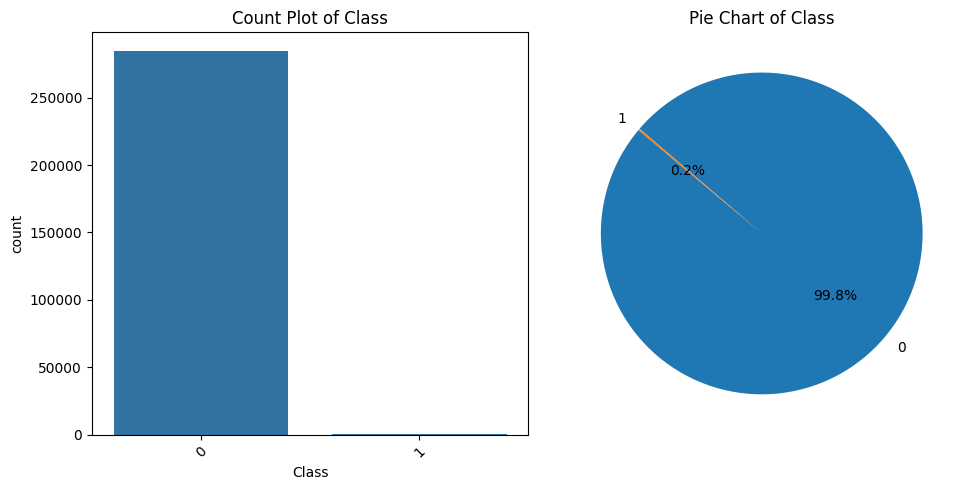

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
use_columns = ['Class']
for col in use_columns:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    profile_counts = df[col].value_counts()
    plt.pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart of {col}')
    plt.tight_layout()
    plt.show()
    print(df[col].value_counts())

In [ ]:
# # Scatter plot matrix 散點圖矩陣
# sns.pairplot(df)

# Split Data

資料分割，將資料集拆分為訓練集和測試集，並使用stratify=y，讓訓練資料的分佈與測試資料產生相同的分佈。因為改變的類別的比例是一個嚴重的問題，因此訓練資料的分佈必須要與實際情況越接近越好。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 ,stratify=y)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
print('='*30)
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))
print('='*30)
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts())
print(pd.Series(y_test).value_counts(normalize=True))

X_train: (199364, 30)
X_test: (85443, 30)
y_train: (199364,)
y_test: (85443,)
Class
0    9.98e-01
1    1.73e-03
Name: proportion, dtype: float64
Class
0    199020
1       344
Name: count, dtype: int64
Class
0    9.98e-01
1    1.73e-03
Name: proportion, dtype: float64
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    9.98e-01
1    1.73e-03
Name: proportion, dtype: float64


In [ ]:
# 列出訓練資料和測試資料的標籤個數
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 199020, 1: 344})
Testing target statistics: Counter({0: 85295, 1: 148})


# Model

In [ ]:
# ! pip install --upgrade scikit-learn==1.2.2

In [ ]:
import sklearn
import xgboost
print(sklearn.__version__)
print(xgboost.__version__)

1.5.2
2.1.1


In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Evaluate

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00       344

    accuracy                           1.00    199364
   macro avg       1.00      1.00      1.00    199364
weighted avg       1.00      1.00      1.00    199364

AUC:
1.0


Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.75      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC:
0.8749589659417316


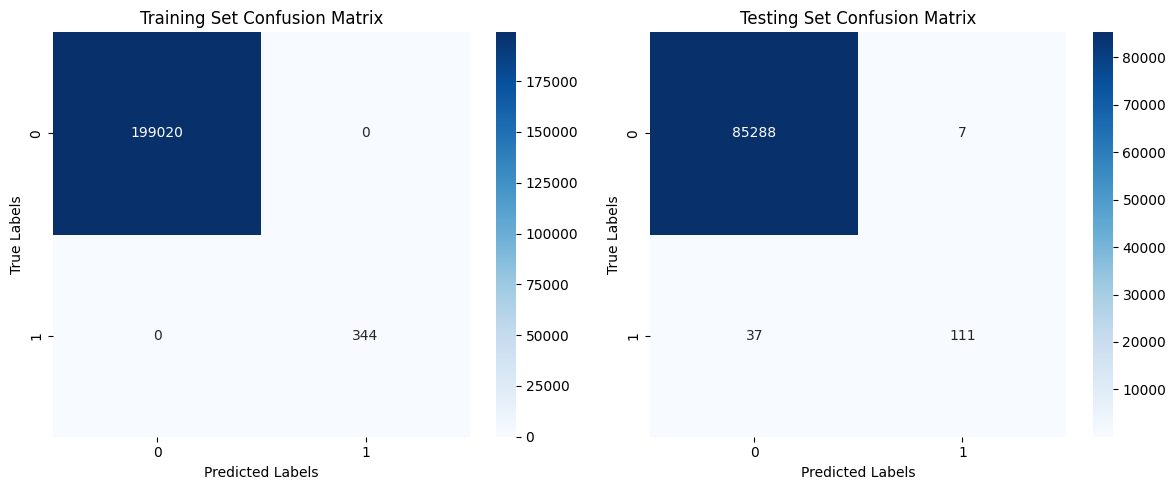

In [ ]:
def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred)
    print("Training Set Evaluation:")
    # print("Accuracy:", train_accuracy)
    # print("Confusion Matrix:")
    # print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("AUC:")
    print(train_auc)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    print("Testing Set Evaluation:")
    # print("Accuracy:", test_accuracy)
    # print("Confusion Matrix:")
    # print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)
    print("AUC:")
    print(test_auc)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Training Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Testing Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()
evaluate_model_performance(xgb_clf, X_train, X_test, y_train, y_test)

模型在訓練或是測試都表現良好，Testing Set中，預測沒有盜刷的precision達到1.00，有盜刷則是0.94，模型的Accuracy則達到了1.00，但評估結果不該只看Accuracy等其他指標，還需輸出混淆矩陣來查看。

*   真實盜刷資料總共有148筆，其中111筆被成功辨識出來，37筆沒有被辨識出來。
*   沒有被盜刷的資料總共有85295筆，其中有7筆資料沒到盜刷卻被預測為有盜刷，剩下的85288筆預測皆正確。

# Learning Curve

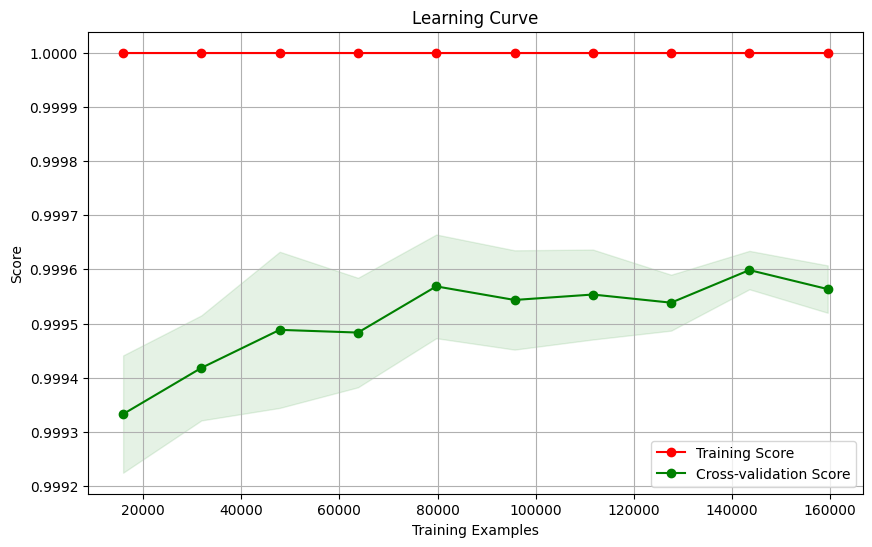

Train Sizes: [ 15949  31898  47847  63796  79745  95694 111643 127592 143541 159491]
Train Scores Mean: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores Mean: [0.99933288 0.99941815 0.99948837 0.99948336 0.99956863 0.99954355
 0.99955358 0.99953853 0.99959872 0.99956361]


In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()
    # Print additional information
    print("Train Sizes:", train_sizes)
    print("Train Scores Mean:", train_scores_mean)
    print("Test Scores Mean:", test_scores_mean)
plot_learning_curve(xgb_clf, X_train, y_train)

*   訓練分數始終保持在高水準（接近 1.0），模型完全擬合了訓練數據，未發生欠擬合。

*   交叉驗證分數隨樣本數量增加逐步提升，並趨於穩定，說明模型的泛化能力隨著更多數據的提供而顯著增強。

*   訓練與驗證分數差距較小，模型沒有出現明顯的過擬合現象，表現出穩健的學習效果。

*   整體來看，該模型在當前配置下具備良好的泛化能力和穩定性。

# SMOTE

In [ ]:
# ! pip install --upgrade imbalanced-learn==0.8.0

In [ ]:
from imblearn.over_sampling import SMOTE
import warnings

# 忽略 FutureWarning 類型的警告
warnings.filterwarnings('ignore', category=FutureWarning)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts())

Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
xgb_smote = xgb.XGBClassifier(random_state=42)
xgb_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00    398040

AUC:
1.0


Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.81      0.83       148

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443

AUC:
0.9052764412222764


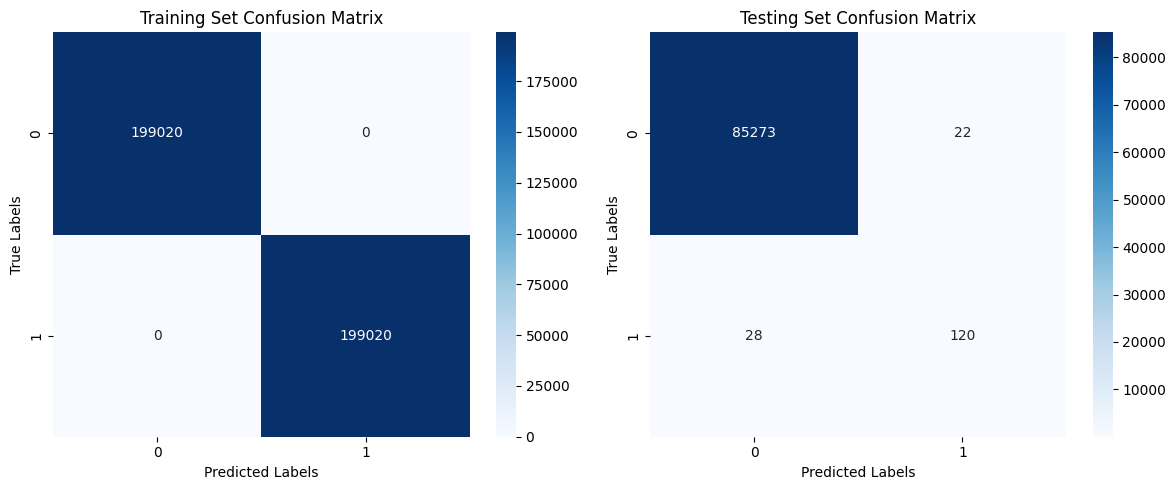

In [ ]:
evaluate_model_performance(xgb_smote, X_train_resampled, X_test, y_train_resampled, y_test)

*   真實盜刷資料總共有148筆，其中120筆被成功辨識出來，28筆沒有被辨識出來。
*   沒有被盜刷的資料總共有85295筆，其中有22筆資料沒到盜刷卻被預測為有盜刷，剩下的85273筆預測皆正確。

# 沒做SMOTE與SMOTE的結果比較：
**1. Class 0 (非詐欺交易)：**

*   NOT SMOTE:
 *   Precision: 1.00
 *   Recall: 1.00
 *   F1-score: 1.00


*   SMOTE:
 *   Precision: 1.00
 *   Recall: 1.00
 *   F1-score: 1.00

**對比結果：**

對於多數類別（非詐欺交易，Class 0），兩者的評估指標完全一致，模型對該類別的預測非常穩定且準確，SMOTE 處理對其性能幾乎沒有影響。

**2. Class 1 (詐欺交易)：**

*   NOT SMOTE:
 *   Precision: 0.94
 *   Recall: 0.75
 *   F1-score: 0.83


*   SMOTE:
 *   Precision: 0.85
 *   Recall: 0.81
 *   F1-score: 0.83

**對比結果：**

*   Precision（精確率）下降：
 *   NOT SMOTE 模型在 Class 1 上有較高的精確率 (0.94)，而 SMOTE 模型略低 (0.85)，這表明在 SMOTE 處理後，模型在判斷為詐欺交易時的準確性稍有下降，可能產生更多的誤報（假正例，FP）。
*   Recall（召回率）提升：
 *   SMOTE 模型的召回率 (0.81) 高於 NOT SMOTE 模型 (0.75)，這表示 SMOTE 處理後模型對詐欺交易的識別能力有所提升，減少了漏報（假負例，FN）。
*   F1-score（平衡指標）不變：
 *   雖然 Precision 和 Recall 有所變化，但兩者的 F1-score 均為 0.83，表明整體平衡性能相當。



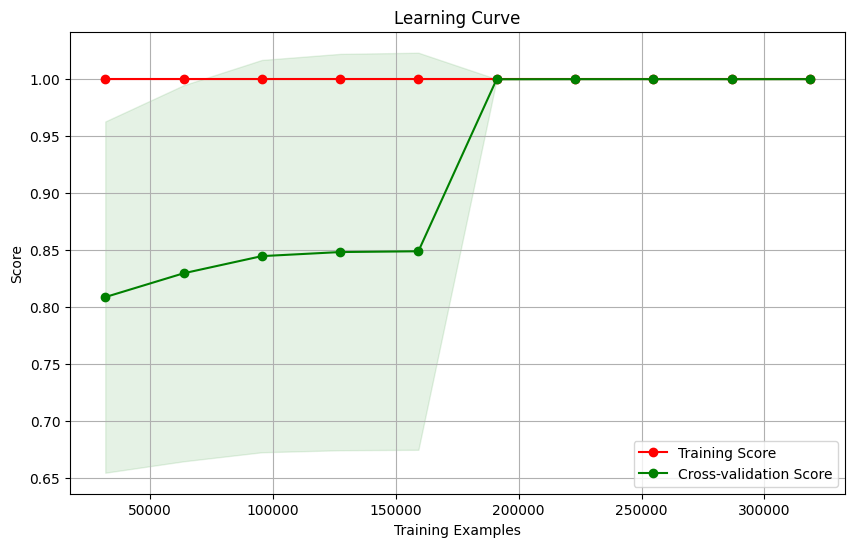

Train Sizes: [ 31843  63686  95529 127372 159216 191059 222902 254745 286588 318432]
Train Scores Mean: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test Scores Mean: [0.80844387 0.8293463  0.84443021 0.84800271 0.8486936  0.99977389
 0.99983419 0.99985177 0.99981911 0.99983921]


In [ ]:
plot_learning_curve(xgb_smote, X_train_resampled, y_train_resampled)

*   **訓練分數**始終接近 1.0，模型在訓練集上能夠很好地擬合數據。

*   **交叉驗證分數**隨樣本數量的增加而顯著提升，並趨於穩定，顯示出模型的良好泛化能力。

*   **兩條曲線之間的差距逐漸縮小**，反映了模型訓練與驗證性能的高度一致性，並表明模型不存在明顯的過擬合。

*   **整體性能提升與穩定性**表明：在當前數據和配置下，模型能很好地學習並適應數據特徵，適合進一步部署和應用。

# Optuna


In [ ]:
def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  # 對訓練資料進行 SMOTE 處理
  smote = SMOTE(random_state=42)
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

  # 建立 XGBoost 的 DMatrix
  dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
  dtest = xgb.DMatrix(X_test, label=y_test)

  params = {
    "verbosity": 0,
    'task': 'train',
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "tree_method": "exact",
    "booster": trial.suggest_categorical("booster", ["gbtree"]), # ,"dart" ,"gblinear" # optuna只接受gbtree
    # L2 regularization weight.
    "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    # L1 regularization weight.
    "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    # sampling ratio for training data.
    "subsample": trial.suggest_float("subsample", 0.2, 1.0),
    # sampling according to each tree.
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }
  if params["booster"] == "gbtree" or params["booster"] == "dart":
    # maximum depth of the tree, signifies complexity of the tree.
    params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
    # minimum child weight, larger the term more conservative the tree.
    params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    # defines how selective algorithm is.
    params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  #   # Additional parameters for Dart Booster
  # if params["booster"] == "dart":
  #   params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
  #   params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
  #   params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
  #   params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  bst = xgb.train(params, dtrain)
  preds = bst.predict(dtest)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_test, pred_labels)
  print("Accuracy:", accuracy)
  return accuracy

In [ ]:
# 最大化評估函數的返回值（例如準確率）時，應選擇 "maximize"
# 最小化評估函數的返回值（例如損失函數）時，應選擇 "minimize"
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2024-12-31 17:20:49,180] A new study created in memory with name: no-name-d60abcb1-6d88-4198-8df1-86085e7b2368
[I 2024-12-31 17:20:51,529] Trial 0 finished with value: 0.9820933253748113 and parameters: {'booster': 'gbtree', 'lambda': 3.884956793585296e-05, 'alpha': 0.0009319876766732755, 'subsample': 0.23428744981101612, 'colsample_bytree': 0.8822614329351146, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.0002358332350947364, 'gamma': 0.0023532247538966137, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9820933253748113.


Accuracy: 0.9820933253748113


[I 2024-12-31 17:20:53,094] Trial 1 finished with value: 0.9847500672963262 and parameters: {'booster': 'gbtree', 'lambda': 1.383559039689012e-08, 'alpha': 0.5725263519241208, 'subsample': 0.3043286385246245, 'colsample_bytree': 0.31186617637283387, 'max_depth': 5, 'min_child_weight': 4, 'eta': 1.1126642691042522e-06, 'gamma': 1.149177480863508e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9847500672963262.


Accuracy: 0.9847500672963262


[I 2024-12-31 17:20:54,234] Trial 2 finished with value: 0.9702257645447843 and parameters: {'booster': 'gbtree', 'lambda': 3.981900175287611e-05, 'alpha': 3.307930571867247e-06, 'subsample': 0.9551168326183435, 'colsample_bytree': 0.3992467344732338, 'max_depth': 1, 'min_child_weight': 10, 'eta': 1.0376430592887737e-08, 'gamma': 0.11292442879096448, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9847500672963262.


Accuracy: 0.9702257645447843


[I 2024-12-31 17:20:55,428] Trial 3 finished with value: 0.9808995470664653 and parameters: {'booster': 'gbtree', 'lambda': 3.427958428143079e-08, 'alpha': 0.0030417047793255022, 'subsample': 0.2944389966111398, 'colsample_bytree': 0.29108156671316054, 'max_depth': 3, 'min_child_weight': 10, 'eta': 2.1775581270114713e-06, 'gamma': 0.0767324032949197, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9847500672963262.


Accuracy: 0.9808995470664653


[I 2024-12-31 17:20:59,092] Trial 4 finished with value: 0.9881558465877837 and parameters: {'booster': 'gbtree', 'lambda': 3.1551664848278194e-08, 'alpha': 1.7251655551582858e-05, 'subsample': 0.767442943564286, 'colsample_bytree': 0.5723180892771111, 'max_depth': 7, 'min_child_weight': 7, 'eta': 1.073362624832142e-05, 'gamma': 0.00023123919145335027, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.9881558465877837


[I 2024-12-31 17:21:01,246] Trial 5 finished with value: 0.985639549173133 and parameters: {'booster': 'gbtree', 'lambda': 0.0679774379301538, 'alpha': 1.9784942590561572e-07, 'subsample': 0.9384304060047903, 'colsample_bytree': 0.721240002481039, 'max_depth': 3, 'min_child_weight': 7, 'eta': 6.068304294324975e-07, 'gamma': 3.1565479854291637e-06, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.985639549173133


[I 2024-12-31 17:21:02,682] Trial 6 finished with value: 0.9767798415317814 and parameters: {'booster': 'gbtree', 'lambda': 1.3649854769657008e-05, 'alpha': 0.000636078477565039, 'subsample': 0.2870780124985025, 'colsample_bytree': 0.422705102147131, 'max_depth': 4, 'min_child_weight': 10, 'eta': 2.7088716030029778e-06, 'gamma': 0.0006919033756530042, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.9767798415317814


[I 2024-12-31 17:21:03,938] Trial 7 finished with value: 0.9693128752501667 and parameters: {'booster': 'gbtree', 'lambda': 4.231400895868325e-08, 'alpha': 1.7716665263452304e-07, 'subsample': 0.6912564761621418, 'colsample_bytree': 0.6585554237691383, 'max_depth': 1, 'min_child_weight': 6, 'eta': 0.001854849938115286, 'gamma': 0.007143178325827208, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.9693128752501667


[I 2024-12-31 17:21:05,397] Trial 8 finished with value: 0.974837025853493 and parameters: {'booster': 'gbtree', 'lambda': 1.4783355480929532e-07, 'alpha': 0.00011464343122310485, 'subsample': 0.5172096418343035, 'colsample_bytree': 0.22879214210349402, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.00020203035735647014, 'gamma': 1.5450329566860486e-06, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.974837025853493


[I 2024-12-31 17:21:08,950] Trial 9 finished with value: 0.987570661142516 and parameters: {'booster': 'gbtree', 'lambda': 0.03942023551089589, 'alpha': 1.29696405302305e-07, 'subsample': 0.5872897198453557, 'colsample_bytree': 0.6344281660659409, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.01679667199615809, 'gamma': 0.5661158030808652, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.9881558465877837.


Accuracy: 0.987570661142516


[I 2024-12-31 17:21:14,653] Trial 10 finished with value: 0.9982210362463865 and parameters: {'booster': 'gbtree', 'lambda': 0.001413285062446104, 'alpha': 6.538903899373016e-06, 'subsample': 0.7624295773228378, 'colsample_bytree': 0.9776573890792141, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.5284829980010188, 'gamma': 4.13294585496568e-05, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.9982210362463865.


Accuracy: 0.9982210362463865


[I 2024-12-31 17:21:20,199] Trial 11 finished with value: 0.9985019252601149 and parameters: {'booster': 'gbtree', 'lambda': 0.002690449459485743, 'alpha': 3.757929740810837e-06, 'subsample': 0.7739135861674229, 'colsample_bytree': 0.9665532054267995, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.7150115717037137, 'gamma': 3.667959921039092e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.9985019252601149.


Accuracy: 0.9985019252601149


[I 2024-12-31 17:21:25,386] Trial 12 finished with value: 0.9986423697669792 and parameters: {'booster': 'gbtree', 'lambda': 0.002177764245953507, 'alpha': 2.5271496110864456e-06, 'subsample': 0.8108025804984166, 'colsample_bytree': 0.9593829520719371, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.8852324806038493, 'gamma': 2.3068530289998834e-08, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.9986423697669792.


Accuracy: 0.9986423697669792


[I 2024-12-31 17:21:30,315] Trial 13 finished with value: 0.998735999438222 and parameters: {'booster': 'gbtree', 'lambda': 0.003325193805883412, 'alpha': 1.691758598233832e-08, 'subsample': 0.8337711796209218, 'colsample_bytree': 0.8359580824516798, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.9544920996417796, 'gamma': 2.3763038570573127e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.998735999438222


[I 2024-12-31 17:21:35,349] Trial 14 finished with value: 0.993715108317826 and parameters: {'booster': 'gbtree', 'lambda': 0.5587545947560452, 'alpha': 1.0139937575223635e-08, 'subsample': 0.8735719897099444, 'colsample_bytree': 0.8111068333970644, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.054526753711087235, 'gamma': 1.0764678763543218e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.993715108317826


[I 2024-12-31 17:21:39,085] Trial 15 finished with value: 0.9914679962079983 and parameters: {'booster': 'gbtree', 'lambda': 0.0007923960704844136, 'alpha': 1.1122628126352959e-08, 'subsample': 0.45917820492155836, 'colsample_bytree': 0.825042044160787, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.027483529308690857, 'gamma': 2.588041667721205e-08, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.9914679962079983


[I 2024-12-31 17:21:44,429] Trial 16 finished with value: 0.995810072211884 and parameters: {'booster': 'gbtree', 'lambda': 2.310372543041373e-06, 'alpha': 5.698958230489599e-07, 'subsample': 0.8587257800923119, 'colsample_bytree': 0.8893225527103517, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.13500312025158234, 'gamma': 1.2285932635053984e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.995810072211884


[I 2024-12-31 17:21:49,029] Trial 17 finished with value: 0.9928022190232084 and parameters: {'booster': 'gbtree', 'lambda': 0.012462577234177994, 'alpha': 0.022113733869206554, 'subsample': 0.6602421959963483, 'colsample_bytree': 0.7509027773200703, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.0008363359359427925, 'gamma': 1.6628869084564045e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.9928022190232084


[I 2024-12-31 17:21:52,495] Trial 18 finished with value: 0.9910349589785002 and parameters: {'booster': 'gbtree', 'lambda': 0.00022767010920069638, 'alpha': 3.2501772443379246e-08, 'subsample': 0.8543704282583541, 'colsample_bytree': 0.5183433382710485, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.005312990937682017, 'gamma': 1.6068921531987003e-07, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.998735999438222.


Accuracy: 0.9910349589785002


[I 2024-12-31 17:21:57,871] Trial 19 finished with value: 0.9988764439450862 and parameters: {'booster': 'gbtree', 'lambda': 0.5974939185926917, 'alpha': 4.2657543678757174e-05, 'subsample': 0.9922304636657554, 'colsample_bytree': 0.884607668993568, 'max_depth': 10, 'min_child_weight': 2, 'eta': 0.9865301013280257, 'gamma': 5.558470545047175e-06, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9988764439450862


[I 2024-12-31 17:22:02,678] Trial 20 finished with value: 0.9946631087391594 and parameters: {'booster': 'gbtree', 'lambda': 0.8382645053984638, 'alpha': 4.6329375585548566e-05, 'subsample': 0.9971658800486086, 'colsample_bytree': 0.72725456612017, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.1238407309070651, 'gamma': 5.770332818294225e-06, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9946631087391594


[I 2024-12-31 17:22:08,343] Trial 21 finished with value: 0.9986774808936952 and parameters: {'booster': 'gbtree', 'lambda': 0.00722612026468728, 'alpha': 1.2596831375306343e-06, 'subsample': 0.9102282191959327, 'colsample_bytree': 0.9076326602960698, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.6941353925171506, 'gamma': 5.0555453102359465e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9986774808936952


[I 2024-12-31 17:22:14,290] Trial 22 finished with value: 0.9979635546504687 and parameters: {'booster': 'gbtree', 'lambda': 0.10195051617777912, 'alpha': 5.654686268275071e-07, 'subsample': 0.9229083138006735, 'colsample_bytree': 0.8713980762661183, 'max_depth': 10, 'min_child_weight': 2, 'eta': 0.24661268238062314, 'gamma': 4.3568732630675573e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9979635546504687


[I 2024-12-31 17:22:19,513] Trial 23 finished with value: 0.9920063668176445 and parameters: {'booster': 'gbtree', 'lambda': 0.01047357801722289, 'alpha': 0.00011160088111639613, 'subsample': 0.9047358186695984, 'colsample_bytree': 0.8025917584741722, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.009839008664775432, 'gamma': 7.815301164311174e-06, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9920063668176445


[I 2024-12-31 17:22:24,054] Trial 24 finished with value: 0.9907423662558665 and parameters: {'booster': 'gbtree', 'lambda': 0.27808433723113324, 'alpha': 8.894811899588642e-07, 'subsample': 0.9877309010599633, 'colsample_bytree': 0.901063408943943, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.06679123380413064, 'gamma': 5.834474479793641e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9907423662558665


[I 2024-12-31 17:22:29,694] Trial 25 finished with value: 0.9979518509415634 and parameters: {'booster': 'gbtree', 'lambda': 0.009441516187002522, 'alpha': 3.961731712207852e-08, 'subsample': 0.6767032986353749, 'colsample_bytree': 0.9943621120314738, 'max_depth': 10, 'min_child_weight': 3, 'eta': 0.2816135741057414, 'gamma': 5.791120072977687e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9979518509415634


[I 2024-12-31 17:22:34,726] Trial 26 finished with value: 0.9909062181805414 and parameters: {'booster': 'gbtree', 'lambda': 0.00032296215629126773, 'alpha': 2.1891737923639837e-05, 'subsample': 0.8237851693644953, 'colsample_bytree': 0.7728015169638326, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.0027637527904660207, 'gamma': 1.0603168906432249e-05, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9909062181805414


[I 2024-12-31 17:22:39,312] Trial 27 finished with value: 0.989232587807076 and parameters: {'booster': 'gbtree', 'lambda': 0.01933429499989283, 'alpha': 0.0002764698243444567, 'subsample': 0.9082808320173105, 'colsample_bytree': 0.6770271490118315, 'max_depth': 8, 'min_child_weight': 6, 'eta': 3.484654393346103e-05, 'gamma': 1.214604601686194e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.989232587807076


[I 2024-12-31 17:22:43,183] Trial 28 finished with value: 0.9973783692052012 and parameters: {'booster': 'gbtree', 'lambda': 0.003967647950546853, 'alpha': 0.005863069961374833, 'subsample': 0.9984497007486496, 'colsample_bytree': 0.8452368214863484, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.9491185685829288, 'gamma': 3.225767098058256e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9973783692052012


[I 2024-12-31 17:22:48,681] Trial 29 finished with value: 0.9948854792083611 and parameters: {'booster': 'gbtree', 'lambda': 0.1369447894033608, 'alpha': 8.197240445388328e-08, 'subsample': 0.7436024532321339, 'colsample_bytree': 0.9284340116854544, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.038258796289591085, 'gamma': 5.081771885860321e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9948854792083611


[I 2024-12-31 17:22:51,239] Trial 30 finished with value: 0.977329915850333 and parameters: {'booster': 'gbtree', 'lambda': 6.84078106814434e-06, 'alpha': 1.0362741581829295e-05, 'subsample': 0.41089629810873585, 'colsample_bytree': 0.9075779458778638, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.000838775153702256, 'gamma': 3.4532118731829714e-05, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.977329915850333


[I 2024-12-31 17:22:56,725] Trial 31 finished with value: 0.9987008883115059 and parameters: {'booster': 'gbtree', 'lambda': 0.0005884254378037356, 'alpha': 1.75812817974144e-06, 'subsample': 0.8884273244142566, 'colsample_bytree': 0.9364247422545018, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.824204394850997, 'gamma': 2.9775947422424686e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9987008883115059


[I 2024-12-31 17:23:02,044] Trial 32 finished with value: 0.9972262209894316 and parameters: {'booster': 'gbtree', 'lambda': 0.0004373979702439758, 'alpha': 1.3848464386660078e-06, 'subsample': 0.8223297476543091, 'colsample_bytree': 0.8495269850396832, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2139194500227682, 'gamma': 5.3286056696427044e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9972262209894316


[I 2024-12-31 17:23:08,142] Trial 33 finished with value: 0.9930714043280315 and parameters: {'booster': 'gbtree', 'lambda': 8.202323537338831e-05, 'alpha': 0.5196266489162764, 'subsample': 0.9342994619438371, 'colsample_bytree': 0.9456472973410575, 'max_depth': 10, 'min_child_weight': 9, 'eta': 1.6580940356063624e-07, 'gamma': 6.467579962185932e-07, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9930714043280315


[I 2024-12-31 17:23:13,377] Trial 34 finished with value: 0.9974017766230119 and parameters: {'booster': 'gbtree', 'lambda': 8.204913022404516e-05, 'alpha': 4.481602511296985e-07, 'subsample': 0.8610004406316013, 'colsample_bytree': 0.7921955299011285, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2868972109223237, 'gamma': 1.4439739387874037e-06, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9974017766230119


[I 2024-12-31 17:23:18,358] Trial 35 finished with value: 0.993516145266435 and parameters: {'booster': 'gbtree', 'lambda': 0.006285902328397174, 'alpha': 3.3098822864345734e-05, 'subsample': 0.9583951958863044, 'colsample_bytree': 0.86560628512866, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.0869991239164876, 'gamma': 8.535300491766713e-08, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.993516145266435


[I 2024-12-31 17:23:22,804] Trial 36 finished with value: 0.9986072586402631 and parameters: {'booster': 'gbtree', 'lambda': 0.0273204774888583, 'alpha': 2.0220967565901623e-06, 'subsample': 0.8900212467449109, 'colsample_bytree': 0.582809243211126, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.9291744040671643, 'gamma': 0.007572168792102811, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9986072586402631


[I 2024-12-31 17:23:27,416] Trial 37 finished with value: 0.9867748089369521 and parameters: {'booster': 'gbtree', 'lambda': 2.3209973676041016e-05, 'alpha': 0.001664219575628331, 'subsample': 0.9589380946776359, 'colsample_bytree': 0.9978928157277176, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.011562151232079007, 'gamma': 0.00023536115766583548, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9867748089369521


[I 2024-12-31 17:23:31,043] Trial 38 finished with value: 0.9921468113245088 and parameters: {'booster': 'gbtree', 'lambda': 0.0009358914160519007, 'alpha': 7.602869043562363e-06, 'subsample': 0.7161599874451339, 'colsample_bytree': 0.5269166203146095, 'max_depth': 9, 'min_child_weight': 9, 'eta': 7.87886420514372e-08, 'gamma': 2.3395614708709607e-08, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9921468113245088


[I 2024-12-31 17:23:32,311] Trial 39 finished with value: 0.9848788080942851 and parameters: {'booster': 'gbtree', 'lambda': 7.348783883447998e-07, 'alpha': 0.0004209461209165836, 'subsample': 0.21131041274001344, 'colsample_bytree': 0.9251387423367591, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.3792778154793139, 'gamma': 2.020260506720235e-06, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.9988764439450862.


Accuracy: 0.9848788080942851
Number of finished trials:  40
Best trial:
  Value: 0.9988764439450862
  Params: 
    booster: gbtree
    lambda: 0.5974939185926917
    alpha: 4.2657543678757174e-05
    subsample: 0.9922304636657554
    colsample_bytree: 0.884607668993568
    max_depth: 10
    min_child_weight: 2
    eta: 0.9865301013280257
    gamma: 5.558470545047175e-06
    grow_policy: lossguide


In [ ]:
trial.params

{'booster': 'gbtree',
 'lambda': 0.5974939185926917,
 'alpha': 4.2657543678757174e-05,
 'subsample': 0.9922304636657554,
 'colsample_bytree': 0.884607668993568,
 'max_depth': 10,
 'min_child_weight': 2,
 'eta': 0.9865301013280257,
 'gamma': 5.558470545047175e-06,
 'grow_policy': 'lossguide'}

In [ ]:
import nbformat
print(nbformat.__version__)

5.10.4


In [ ]:
# from optuna.visualization import plot_optimization_history

# plotly_config = {"staticPlot": True}

# fig = plot_optimization_history(study)
# fig.show(config=plotly_config)

In [ ]:
from optuna.visualization import plot_optimization_history
import plotly.io as pio

pio.renderers.default = 'browser'  # 或者 'notebook'

fig = plot_optimization_history(study)
fig.show()

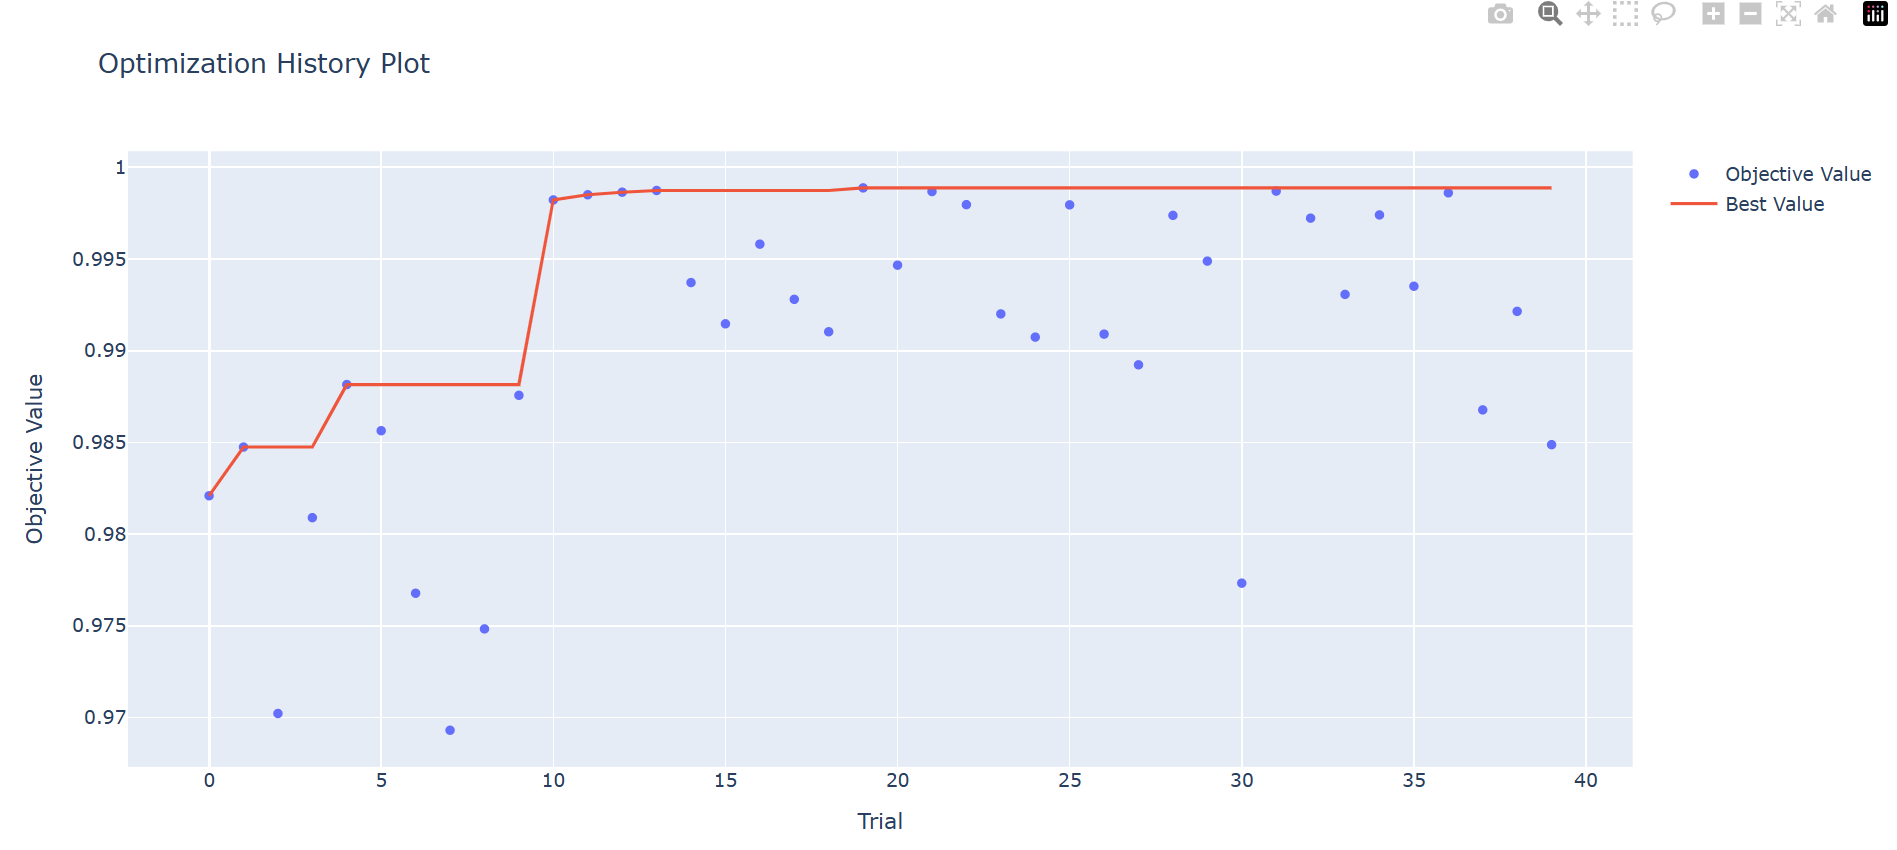

我們進行了**40次不同參數組合的試驗**，旨在尋找最佳設置。從圖表中可以觀察到，Objective Value在試驗過程中存在一定波動，但整體趨勢是**逐漸上升**的。Best Value的線條顯示出最佳結果在試驗進行到第10次左右時，已經達到穩定的高水平，之後基本維持不變。

這表明經過幾次試驗調整後，算法快速收斂至接近最優解，隨後的試驗並未顯著提升最佳值，可能是因為模型已經找到了最合適的參數範圍。

In [ ]:
from optuna.visualization import plot_param_importances

# fig = plot_param_importances(study)
# fig.show(config=plotly_config)

In [ ]:
from optuna.visualization import plot_param_importances

pio.renderers.default = 'browser'  # 或者 'notebook'

fig = plot_param_importances(study)
fig.show()

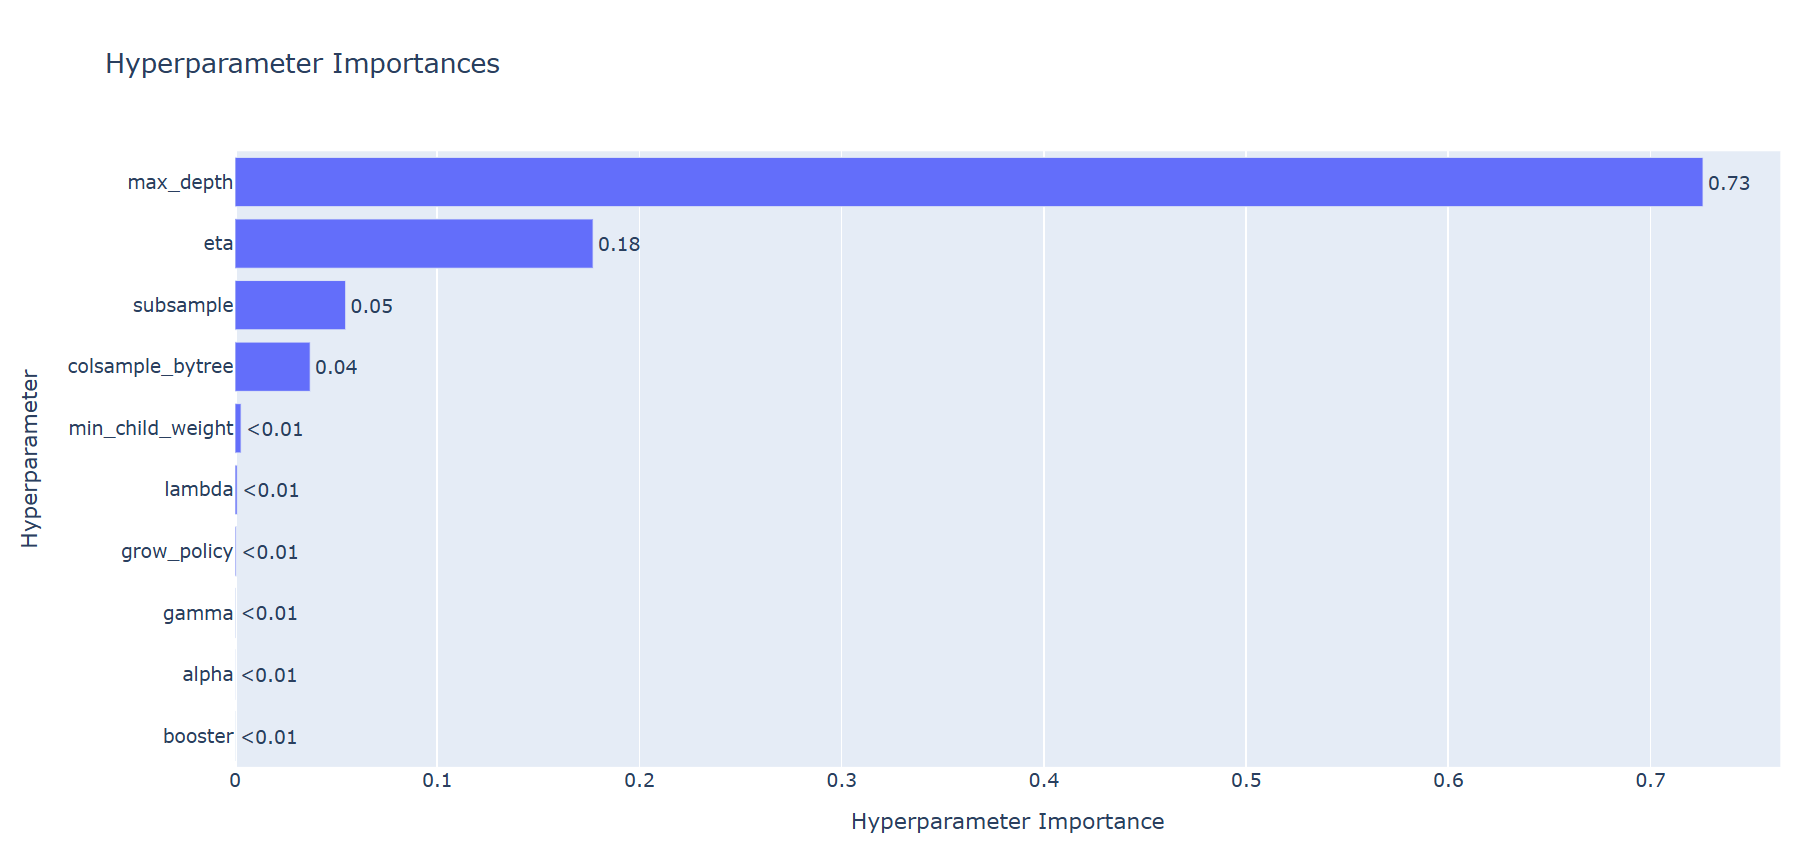

*   從 Optuna 輸出的超參數重要性視覺化圖表可以看出，**max_depth（決策樹的最大深度）**對模型影響最大，其重要性值達到 0.73，遠高於其他參數。其次是 **eta（learning_rate，學習率）**，重要性為 0.18，顯示這兩個參數在優化過程中對目標值的影響最為顯著。
*   另外，subsample（樣本隨機採樣比例）和 colsample_bytree（每棵樹隨機選擇的特徵比例）分別有 0.05 和 0.04 的影響，但相對較低。而 min_child_weight、lambda（L2 正則化）、grow_policy 等參數的影響值均低於 0.01，可視為對結果影響甚微。

In [ ]:
# 最後將訓練好的params，傳遞給XGBClassifier，重新fit資料。
xgb_clf = xgb.XGBClassifier(**trial.params, random_state=42)
# xgb_clf.fit(X, y)
xgb_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(alpha=4.2657543678757174e-05, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.884607668993568, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.9865301013280257, eval_metric=None, feature_types=None,
              gamma=5.558470545047175e-06, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              lambda=0.5974939185926917, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00    398040

AUC:
1.0


Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.82      0.81       148

    accuracy                           1.00     85443
   macro avg       0.89      0.91      0.90     85443
weighted avg       1.00      1.00      1.00     85443

AUC:
0.9119687158874684


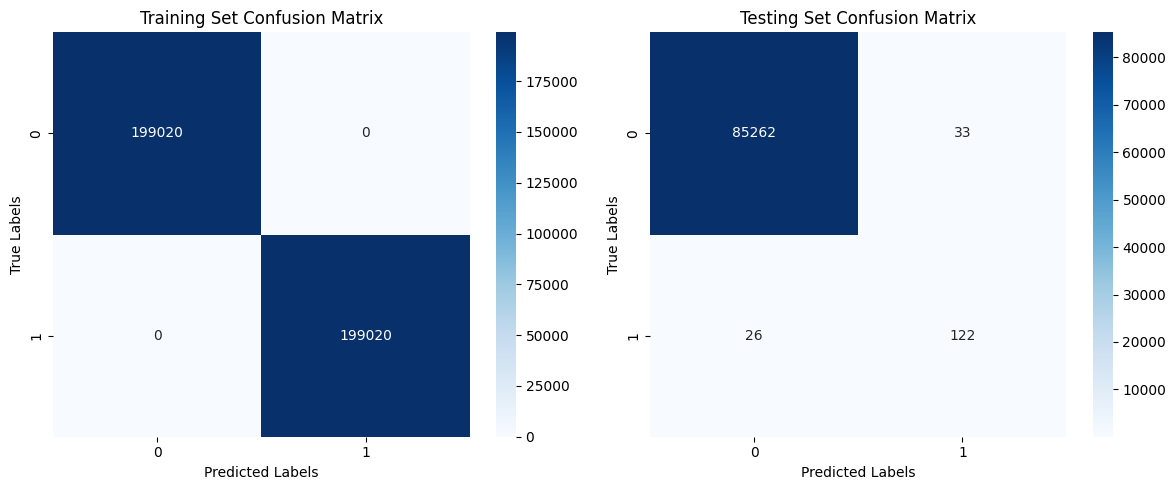

In [ ]:
evaluate_model_performance(xgb_clf, X_train_resampled, X_test, y_train_resampled, y_test)

*   真實盜刷資料總共有148筆，其中122筆被成功辨識出來，26筆沒有被辨識出來。
*   沒有被盜刷的資料總共有85295筆，其中有33筆資料沒到盜刷卻被預測為有盜刷，剩下的85262筆預測皆正確。

# SMOTE與SMOTE+Optuna的結果比較：
**1. Class 0 (非詐欺交易)：**

*   SMOTE :
 *   Precision: 1.00
 *   Recall: 1.00
 *   F1-score: 1.00


*   SMOTE + Optuna :
 *   Precision: 1.00
 *   Recall: 1.00
 *   F1-score: 1.00

**對比結果：**

對於多數類別（非詐欺交易，Class 0），兩者的評估指標完全一致，顯示模型對非詐欺交易的預測非常穩定且準確。

Hyperparameter tuning（Optuna）對多數類別的性能幾乎沒有影響，兩個模型在這一類別上的表現均達到了最優水準。

**2. Class 1 (詐欺交易)：**

*   SMOTE:
 *   Precision: 0.85
 *   Recall: 0.81
 *   F1-score: 0.83


*   SMOTE + Optuna:
 *   Precision: 0.79
 *   Recall: 0.82
 *   F1-score: 0.81

**對比結果：**

*   Precision（精確率）下降：
 *   SMOTE 模型的精確率較高（0.85），而 SMOTE + Optuna 模型略低（0.79）。
 *   這表明進行超參數調整後，模型對詐欺交易的分類準確性有所下降，可能產生更多假正例（False Positives, FP）。

*   Recall（召回率）略有提升：
 *   SMOTE + Optuna 模型的召回率為 0.82，稍高於 SMOTE 模型的 0.81。
 *   這表明超參數調整後，模型略微提升了對詐欺交易的識別能力，減少了漏報（False Negatives, FN）

*   F1-score（平衡指標）略下降：
 *   SMOTE 模型的 F1-score 為 0.83，而 SMOTE + Optuna 模型略低（0.81）。
 *   儘管召回率略有提升，但精確率的下降導致 F1-score 整體稍有下降，表明超參數調整後的平衡性能有所折損。

# 結論：

1.   對於多數類別（Class 0），兩個模型的表現完全一致，均能準確識別非詐欺交易。
2.   對於少數類別（Class 1），SMOTE 模型在精確率方面表現較優，而 SMOTE + Optuna 模型在召回率上略有提升，但以精確率下降為代價，導致整體平衡性能（F1-score）略低於 SMOTE 模型。
3.   如果業務需求更加關注召回率（希望盡可能捕捉到詐欺交易），SMOTE + Optuna 模型可以被考慮；但如果精確率更為重要（減少誤報），則單純的 SMOTE 模型可能更適合。




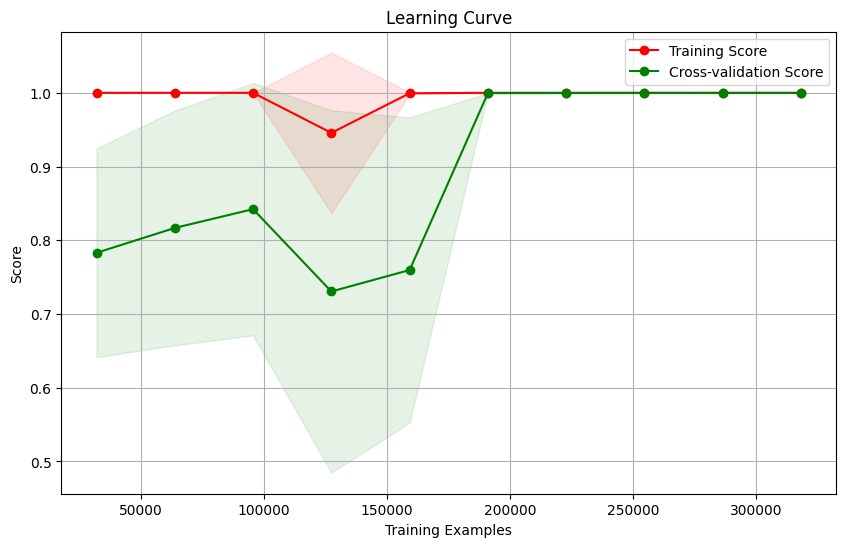

Train Sizes: [ 31843  63686  95529 127372 159216 191059 222902 254745 286588 318432]
Train Scores Mean: [0.99994975 1.         1.         0.94564268 0.99937067 1.
 1.         1.         1.         1.        ]
Test Scores Mean: [0.78299166 0.8167144  0.8422043  0.73053964 0.75963471 0.99962064
 0.99972867 0.99978645 0.99980404 0.99977389]


In [ ]:
plot_learning_curve(xgb_clf, X_train_resampled, y_train_resampled)

*   訓練分數的平均值保持在接近 1.0 的水準，隨著訓練樣本數的增加變化不大，顯示模型能夠很好地擬合訓練數據。

*   交叉驗證分數的平均值隨著訓練樣本數量增加逐漸提升，特別是在樣本數約 200,000 以上時，曲線變得更加穩定，並逐漸接近訓練分數，說明模型的泛化能力隨樣本增長而提升。

*   訓練分數與交叉驗證分數之間的差距逐漸縮小，這表示模型沒有明顯的過擬合現象（overfitting）。隨著樣本數量的增加，兩條曲線趨於穩定，顯示模型在訓練數據和未見數據上都有良好的表現。

*   雖然交叉驗證分數在樣本數較少時波動較大，但隨著樣本數增加，波動幅度顯著降低，表明數據規模的增加有助於提高模型的穩定性。


綜上所述，該模型在隨**樣本數增長**的過程中，表現出**穩定且良好的泛化能力**。後續可以進一步擴大數據規模或優化超參數，以進一步提升模型性能。

# Shap

解釋模型

In [ ]:
# Tree SHAP 來解釋整個資料集
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X)
# shap_values = explainer(X ,y) #　返回一個shap.Explanation

In [ ]:
print("X shape:", X.shape)
print("SHAP values shape:", shap_values.shape)

X shape: (284807, 30)
SHAP values shape: (284807, 30)


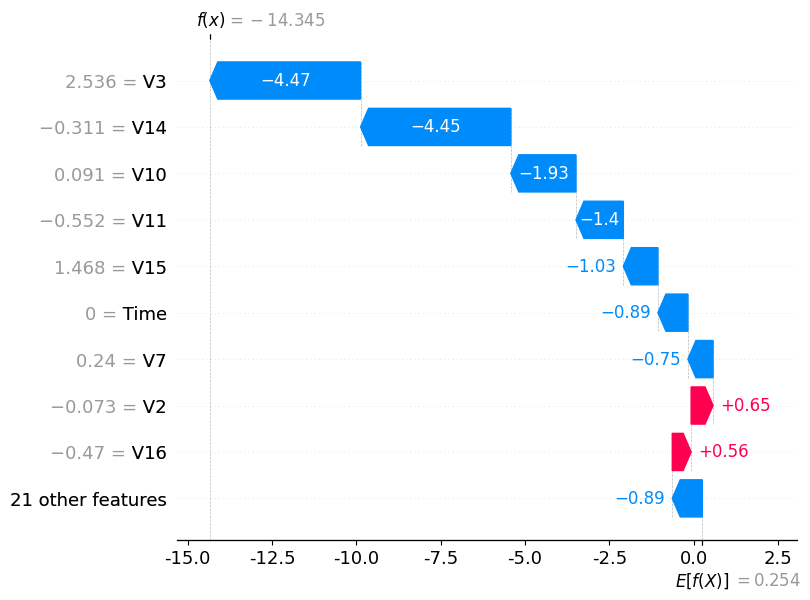

In [ ]:
# waterfall 單筆資料解釋
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0, ...])

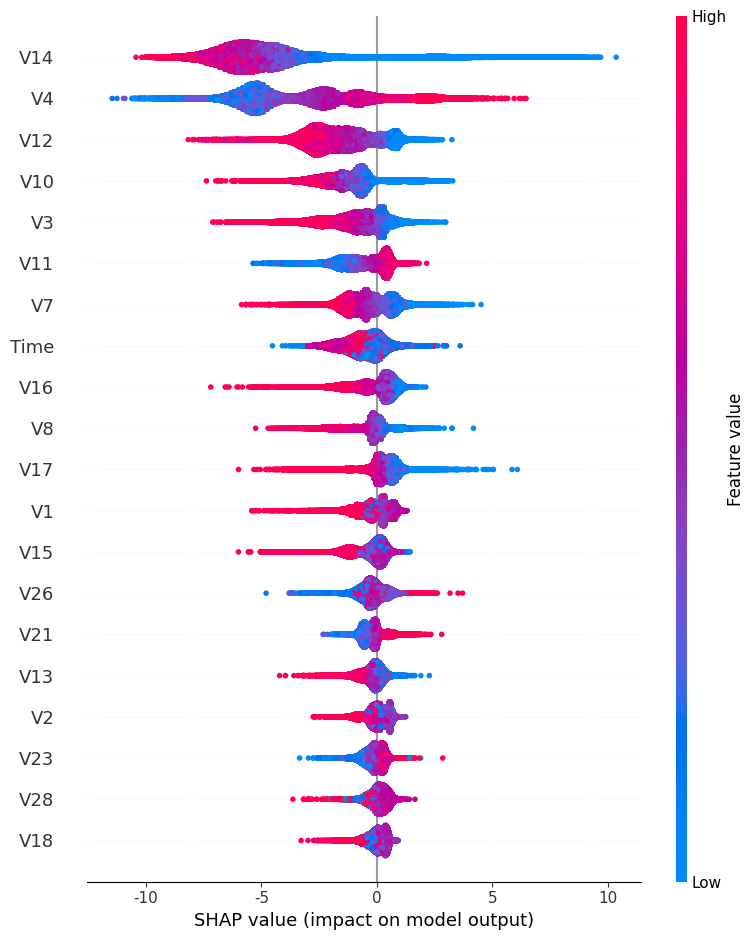

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X)

In [ ]:
# shap.plots.beeswarm(shap_values)

* V4越大，具有更大的總體模型影響
* V14越小，對於預測值的貢獻度越高，反之
* V12的大小,某種程度都會影響預測值




In [ ]:
# # Bar chart of mean importance
# shap.summary_plot(shap_values, X, plot_type="bar")

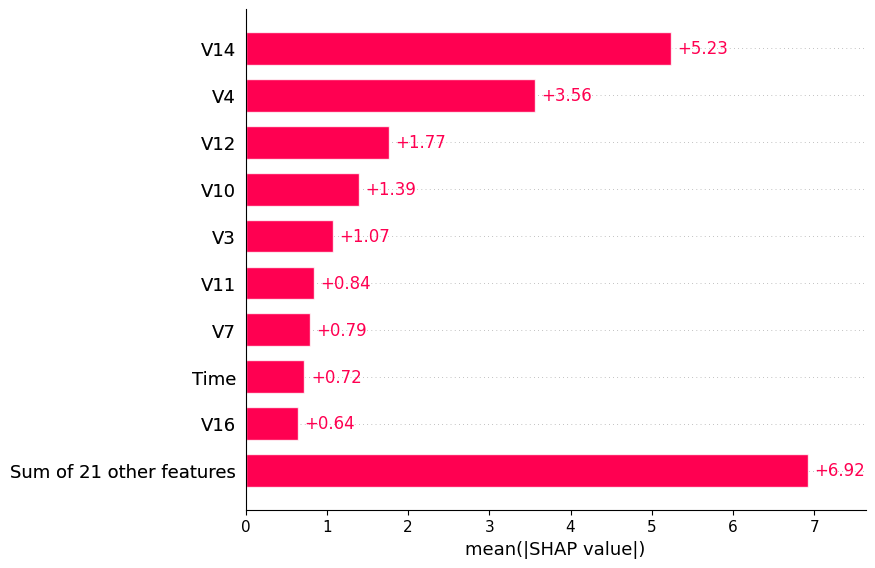

In [ ]:
# Global bar plot
shap.plots.bar(shap_values)

* V14：+5.23
* V4：+3.56
* V12：+1.77

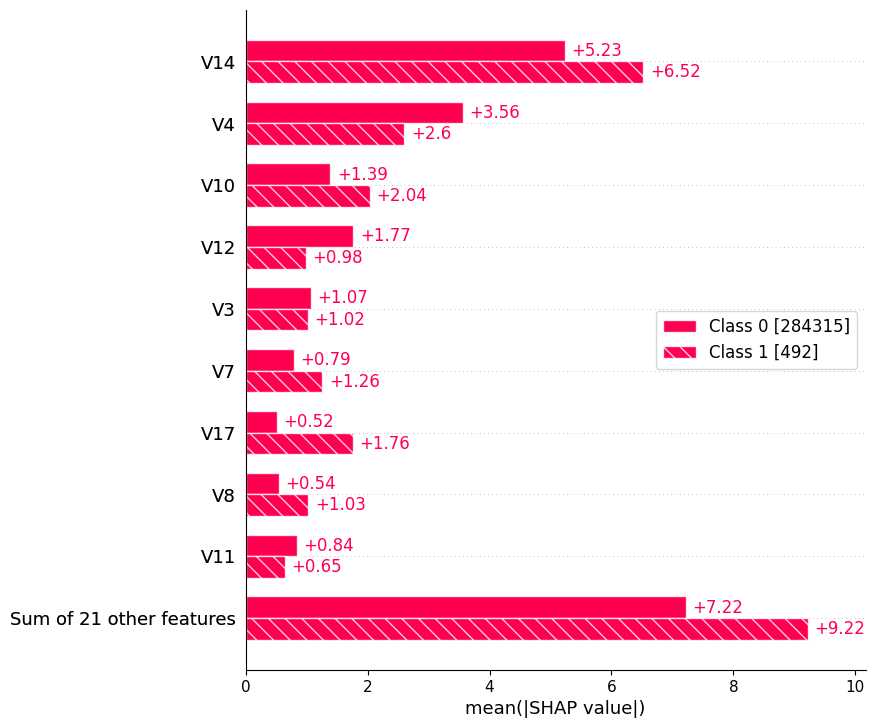

In [ ]:
# Cohort bar plot
cohorts = ["Class 0" if y.iloc[i] == 0 else "Class 1" for i in range(len(y))]

shap_cohorts = shap_values.cohorts(cohorts)
shap.plots.bar(shap_cohorts.abs.mean(0))

* V14和V4對模型預測的影響最大，特別是對於Class1
* V10, V12, V3, V7, V17, V8: 这些特徵也有一定的重要性，但影響不如V14和V4

In [ ]:
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values.values, X_train)